In [1]:
import itertools
import json
import logging
import math
import pathlib
import pickle
import random
import tempfile
from collections import OrderedDict, defaultdict
import random
from sklearn.metrics import accuracy_score
import pandas as pd

#import mir_eval
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import mode as scipy_mode
from sklearn.metrics import average_precision_score, r2_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import glob
import os
import wandb as wandb_lib
from sklearn.metrics import classification_report

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Load the data

In [2]:
# Shape of each representation
npy_paths_clmr = sorted(glob.glob('features_our/clmr/*.npy'))
npy_paths_musicnn = sorted(glob.glob('features_our/musicnn/*.npy'))
npy_paths_jukebox_zeropad = sorted(glob.glob('features_our/jukebox/*.npy'))
npy_paths_pann = sorted(glob.glob('features_our/pann/*.npy'))

# Feature representations
X_clmr = np.array([np.load(p) for p in npy_paths_clmr])
X_musicnn = np.array([np.load(p) for p in npy_paths_musicnn])
X_jukebox_zeropad = np.array([np.load(p) for p in npy_paths_jukebox_zeropad])
X_pann = np.array([np.load(p) for p in npy_paths_pann])

# Labels
y_clmr = np.array([os.path.split(p)[1].split('-')[0] for p in npy_paths_clmr])
y_musicnn = np.array([os.path.split(p)[1].split('-')[0] for p in npy_paths_musicnn])
y_jukebox_zeropad = np.array([os.path.split(p)[1].split('-')[0] for p in npy_paths_jukebox_zeropad])
y_pann = np.array([os.path.split(p)[1].split('-')[0] for p in npy_paths_pann])

In [3]:
DATASET_TO_ATTRS = {
    "dcase": {
        "num_outputs": 10,
        "output_type": "multiclass",
        "labels": """airport, bus, metro, metro_station, park, public_square, shopping_mall, street_pedestrian, street_traffic, tram""".split(
            ", "
        ),
    }}

PAPER_GRID = {
    "data_standardization": [False, True],
    "hidden_layer_sizes": [[], [512]],
    "batch_size": [64, 256],
    "learning_rate": [1e-5, 1e-4, 1e-3],
    "dropout_p": [0.25, 0.5, 0.75],
    "l2_weight_decay": [None, 1e-4, 1e-3],
}

In [4]:
cfg = {
        "dataset": None,
        "representation": None,
        "data_standardization": True,
        "hidden_layer_sizes": [],
        "batch_size": 64,
        "learning_rate": 1e-3,
        "dropout_input": True,
        "dropout_p": 0.5,
        "l2_weight_decay": None,
        "max_num_epochs": 50,
        "early_stopping_metric": "primary",
        "early_stopping": True,
        "early_stopping_eval_frequency": 8,
        "early_stopping_boredom": 256,
        "seed": 0,
    }

### Train-validation-test split (70-20-10 ratio)

In [5]:
from sklearn.model_selection import train_test_split

train_ratio = 0.7
test_ratio = 0.2
valid_ratio = 0.1

def split_data(X,y,train_ratio,test_ratio,valid_ratio):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1-train_ratio, random_state = 42)
    X_valid, X_test, y_valid, y_test = train_test_split(X_test,y_test, test_size=test_ratio/(test_ratio + valid_ratio), random_state=42)
    return X_train, X_test, X_valid, y_train, y_test, y_valid

# Clmr
X_train_clmr, X_test_clmr, X_valid_clmr, y_train_clmr, y_test_clmr, y_valid_clmr = split_data(X_clmr, y_clmr, train_ratio, test_ratio, valid_ratio)
X_train_musicnn, X_test_musicnn, X_valid_musicnn, y_train_musicnn, y_test_musicnn, y_valid_musicnn = split_data(X_musicnn, y_musicnn, train_ratio, test_ratio, valid_ratio)
X_train_jukebox_zeropad, X_test_jukebox_zeropad, X_valid_jukebox_zeropad, y_train_jukebox_zeropad, y_test_jukebox_zeropad, y_valid_jukebox_zeropad = split_data(X_jukebox_zeropad, y_jukebox_zeropad, train_ratio, test_ratio, valid_ratio)
X_train_pann, X_test_pann, X_valid_pann, y_train_pann, y_test_pann, y_valid_pann = split_data(X_pann, y_pann, train_ratio, test_ratio, valid_ratio)

## Check class proportion

In [6]:
def check_equal_class(label):
    assert len(pd.Series(label).unique()) == 10, "Length of the labels should be 10, check again"
    
    print("There are enough classes")

In [7]:
check_equal_class(y_valid_clmr)
check_equal_class(y_valid_musicnn)
check_equal_class(y_valid_jukebox_zeropad)
check_equal_class(y_valid_pann)

There are enough classes
There are enough classes
There are enough classes


AssertionError: Length of the labels should be 10, check again

## Check class imbalance

In [8]:
import pandas as pd

labels = [y_train_clmr, y_train_jukebox_zeropad, y_train_musicnn]

for df in labels:
    print(pd.Series(df).value_counts())
    print()

street_pedestrian    977
street_traffic       972
public_square        966
park                 963
metro_station        889
shopping_mall        847
bus                  804
tram                 772
metro                733
airport              680
dtype: int64

park                 937
metro_station        885
shopping_mall        865
public_square        828
street_traffic       828
street_pedestrian    817
bus                  783
tram                 748
metro                738
airport              682
dtype: int64

street_pedestrian    977
street_traffic       972
public_square        966
park                 963
metro_station        889
shopping_mall        847
bus                  804
tram                 772
metro                733
airport              680
dtype: int64



In [9]:
split_to_X = defaultdict(lambda: defaultdict(list))
split_to_y = defaultdict(lambda: defaultdict(list))

split_to_X["clmr"]["train"] = X_train_clmr
split_to_X["clmr"]["validation"] = X_valid_clmr
split_to_X["clmr"]["test"] = X_test_clmr
split_to_y["clmr"]["train"] = y_train_clmr
split_to_y["clmr"]["validation"] = y_valid_clmr
split_to_y["clmr"]["test"] = y_test_clmr

split_to_X["musicnn"]["train"] = X_train_musicnn
split_to_X["musicnn"]["validation"] = X_valid_musicnn
split_to_X["musicnn"]["test"] = X_test_musicnn
split_to_y["musicnn"]["train"] = y_train_musicnn
split_to_y["musicnn"]["validation"] = y_valid_musicnn
split_to_y["musicnn"]["test"] = y_test_musicnn

split_to_X["jukebox"]["train"] = X_train_jukebox_zeropad
split_to_X["jukebox"]["validation"] = X_valid_jukebox_zeropad
split_to_X["jukebox"]["test"] = X_test_jukebox_zeropad
split_to_y["jukebox"]["train"] = y_train_jukebox_zeropad
split_to_y["jukebox"]["validation"] = y_valid_jukebox_zeropad
split_to_y["jukebox"]["test"] = y_test_jukebox_zeropad

## Define the Simple Neural Network

In [17]:
class SimpleMLP(nn.Module):
    def __init__(
        self,
        num_features,
        hidden_layer_sizes,
        num_outputs,
        dropout_input=True,
        dropout_p=0.5,
    ):
        super().__init__()
        d = num_features
        self.num_layers = 1
        for i, ld in enumerate(hidden_layer_sizes):
            setattr(self, f"hidden_{i}", nn.Linear(d, ld))
            d = ld
        self.output = nn.Linear(d, num_outputs)
        self.dropout = nn.Dropout(p=dropout_p)
        self.softmax = nn.Softmax()

    def forward(self, x, **kwargs):
        x = self.dropout(x)
        for i in range(self.num_layers):
            x = getattr(self, f"hidden_{i}")(x)
            x = F.relu(x)
            x = self.dropout(x)
        x = self.output(x)
        classes_proba = self.softmax(x)
        return x, classes_proba

In [18]:
scaler_dict = {}
le_dict = {}

## Clmr

In [19]:
# Standard scaler
std_scaler_clmr = StandardScaler()
X_train_clmr = std_scaler_clmr.fit_transform(split_to_X["clmr"]["train"])
X_valid_clmr = std_scaler_clmr.fit_transform(split_to_X["clmr"]["validation"])

scaler_dict["clmr"] = std_scaler_clmr

# Label encoding
le_clmr = preprocessing.LabelEncoder()
y_train_clmr = le_clmr.fit_transform(split_to_y["clmr"]["train"])
y_valid_clmr = le_clmr.fit_transform(split_to_y["clmr"]["validation"])

le_dict["clmr"] = le_clmr

In [20]:
probe_clmr = SimpleMLP(
            num_features = split_to_X["clmr"]["train"].shape[1],
            hidden_layer_sizes = [512],
            num_outputs = DATASET_TO_ATTRS["dcase"]["num_outputs"],
            dropout_input=True,
            dropout_p=0.25,
        )

probe_clmr.to(device)

SimpleMLP(
  (hidden_0): Linear(in_features=512, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (softmax): Softmax(dim=None)
)

In [21]:
# Create optimizer
optimizer = torch.optim.Adam(
    probe_clmr.parameters(),
    lr=cfg["learning_rate"],
    weight_decay=0
    if cfg["l2_weight_decay"] is None
    else cfg["l2_weight_decay"],
)

In [22]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [ ]:
proba

In [67]:
def train_valid_loop(X_train, y_train, X_valid, y_valid, model, cfg, std_scaler, label_encod, optim):
    summarize_frequency = 10
    loss = nn.CrossEntropyLoss()
    epoch = 0
    target_names = label_encod.classes_
    loss_per_epochs = []
    val_loss_per_epochs = []
    accuracy_per_epochs = []
    proba_classes_val = []
    
    while True:
        ### Training phase ###
        # Put the model into train mode
        model.train()

        # Check if exceeded max num epochs
        if epoch == cfg["max_num_epochs"]:
            break

        # Create batch
        idxs_train = random.sample(
            list(range(X_train.shape[0])),
            min(cfg["batch_size"], X_train.shape[0]),
        )

        X, y = X_train[idxs_train], y_train[idxs_train]

        X = torch.tensor(X, dtype=torch.float32, device=device)
        y = torch.tensor(y, device=device)

        # Update
        optimizer.zero_grad()

        y_pred, proba_classes = model(X)
        loss_train = loss(y_pred, y)
        
        loss_per_epochs.append(loss_train.item())

        loss_train.backward()
        optimizer.step()
        epoch += 1

        ########### Validation phase ###############
        model.eval()

        # Create batch
        idxs_val = random.sample(
            list(range(X_valid.shape[0])),
            min(cfg["batch_size"], X_valid.shape[0]),
        )
        X_valid, y_valid = X_valid[idxs_val], y_valid[idxs_val]

        X_valid = torch.tensor(X_valid, dtype=torch.float32, device=device)
        y_valid = torch.tensor(y_valid, device=device)
        
        y_pred_valid, proba_classes_valid = model(X_valid)
        
        '''
        proba_classes_valid = torch.argmax(proba_classes_valid, dim=1)
        
        print(proba_classes_valid)
        
        fpr, tpr, _ = roc_curve(y_valid, proba_classes_valid)
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()
        
        #proba_classes_val[idxs_val] = proba_classes_valid
        
        #proba_classes_val.append(proba_classes_valid)
        '''
        loss_valid = loss(y_pred_valid, y_valid)
        
        val_loss_per_epochs.append(loss_valid.item())
        
        y_pred_labels = []
        for tensor in y_pred_valid:
            pred = torch.argmax(tensor)
            y_pred_labels.append(pred)
            
        acc_valid = accuracy_score(y_valid, y_pred_labels)
        accuracy_per_epochs.append(acc_valid)
        
        
        # Summarize
        if epoch % summarize_frequency == 0:
            loss_train = loss_train.item()
            loss_valid = loss_valid.item()
            print("Epoch {}, train_loss: {}, valid_loss: {}".format(epoch, loss_train, loss_valid))

        try:
            if epoch % 10 == 0:
                print(classification_report(y_valid, y_pred_labels, target_names=target_names))
        except ValueError:
            print(np.unique(y_valid))
            print()
            print(np.unique(y_pred_labels))
    
    print(proba_classes_val)
    return loss_per_epochs, val_loss_per_epochs, accuracy_per_epochs, proba_classes_val

In [68]:
train_losses, val_losses, acc_epochs, proba_classes_val = train_valid_loop(X_train_clmr, y_train_clmr, X_valid_clmr, y_valid_clmr, probe_clmr, cfg, std_scaler_clmr, le_clmr, optimizer)

Epoch 10, train_loss: 0.7784952521324158, valid_loss: 0.6993699669837952
                   precision    recall  f1-score   support

          airport       0.80      0.67      0.73         6
              bus       1.00      1.00      1.00         5
            metro       0.83      0.71      0.77         7
    metro_station       0.80      1.00      0.89         4
             park       0.75      1.00      0.86         9
    public_square       0.67      0.50      0.57         8
    shopping_mall       0.67      0.80      0.73         5
street_pedestrian       0.62      0.50      0.56        10
   street_traffic       1.00      1.00      1.00         8
             tram       0.33      0.50      0.40         2

         accuracy                           0.77        64
        macro avg       0.75      0.77      0.75        64
     weighted avg       0.77      0.77      0.76        64

Epoch 20, train_loss: 0.7050198912620544, valid_loss: 0.6846303939819336
                   precis

In [36]:
def plot_losses(train_losses, valid_losses, acc):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
    axes[0].plot(train_losses)
    axes[1].plot(valid_losses)
    axes[0].set_title("Train losses")
    axes[1].set_title("Valid losses")
    
    axes[2].plot(acc)
    axes[2].set_title("Accuracy")
    plt.show()

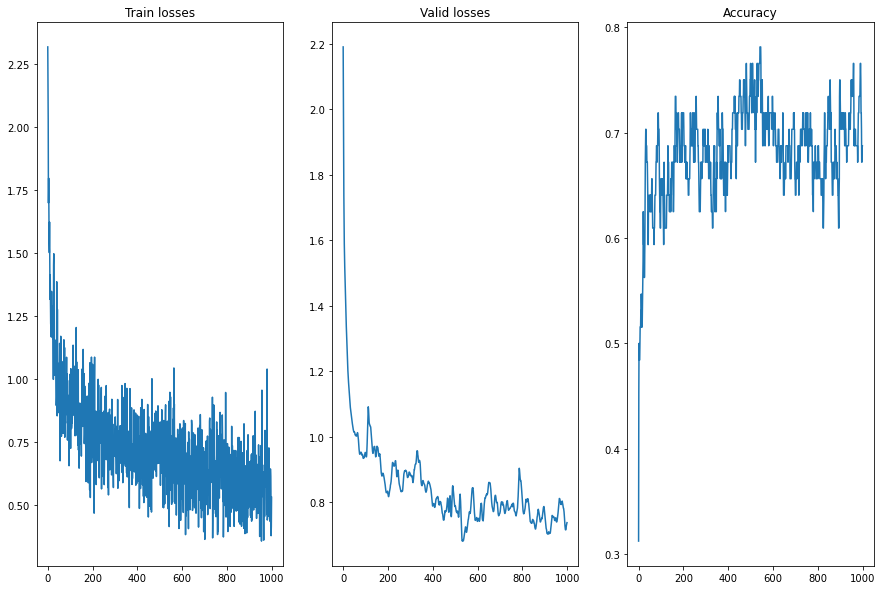

In [125]:
plot_losses(train_losses, val_losses, acc_epochs)

In [29]:
mean_avg = np.mean(acc_epochs)
print("Mean average {}".format(mean_avg))

Mean average 0.665625


## Musicnn

In [30]:
probe_musicnn = SimpleMLP(
            num_features = split_to_X["musicnn"]["train"].shape[1],
            hidden_layer_sizes = [512],
            num_outputs = DATASET_TO_ATTRS["dcase"]["num_outputs"],
            dropout_input=True,
            dropout_p=0.25,
        )

probe_musicnn.to(device)

SimpleMLP(
  (hidden_0): Linear(in_features=4194, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [37]:
# Standard scaler
std_scaler_musicnn = StandardScaler()
X_train_musicnn = std_scaler_clmr.fit_transform(split_to_X["musicnn"]["train"])
X_valid_musicnn = std_scaler_clmr.fit_transform(split_to_X["musicnn"]["validation"])

scaler_dict["musicnn"] = std_scaler_musicnn

# Label encoding
le_musicnn = preprocessing.LabelEncoder()
y_train_musicnn = le_musicnn.fit_transform(split_to_y["musicnn"]["train"])
y_valid_musicnn = le_musicnn.fit_transform(split_to_y["musicnn"]["validation"])

le_dict["musicnn"] = le_musicnn

In [38]:
# Create optimizer
optimizer_musicnn = torch.optim.Adam(
    probe_musicnn.parameters(),
    lr=cfg["learning_rate"],
    weight_decay=0
    if cfg["l2_weight_decay"] is None
    else cfg["l2_weight_decay"],
)

In [39]:
train_losses_musicnn, val_losses_musicnn, acc_epochs_musicnn = train_valid_loop(X_train_musicnn, y_train_musicnn, X_valid_musicnn, y_valid_musicnn, probe_musicnn, cfg, std_scaler_musicnn, le_musicnn, optimizer_musicnn)

Epoch 10, train_loss: 2.316204786300659, valid_loss: 2.2934017181396484
                   precision    recall  f1-score   support

          airport       0.00      0.00      0.00         5
              bus       0.00      0.00      0.00         5
            metro       0.00      0.00      0.00         7
    metro_station       0.00      0.00      0.00         9
             park       0.09      0.33      0.14         3
    public_square       0.00      0.00      0.00         6
    shopping_mall       0.00      0.00      0.00         4
street_pedestrian       0.00      0.00      0.00         8
   street_traffic       0.36      0.31      0.33        13
             tram       0.00      0.00      0.00         4

         accuracy                           0.08        64
        macro avg       0.05      0.06      0.05        64
     weighted avg       0.08      0.08      0.07        64

Epoch 20, train_loss: 2.3236889839172363, valid_loss: 2.2934017181396484
                   precisi

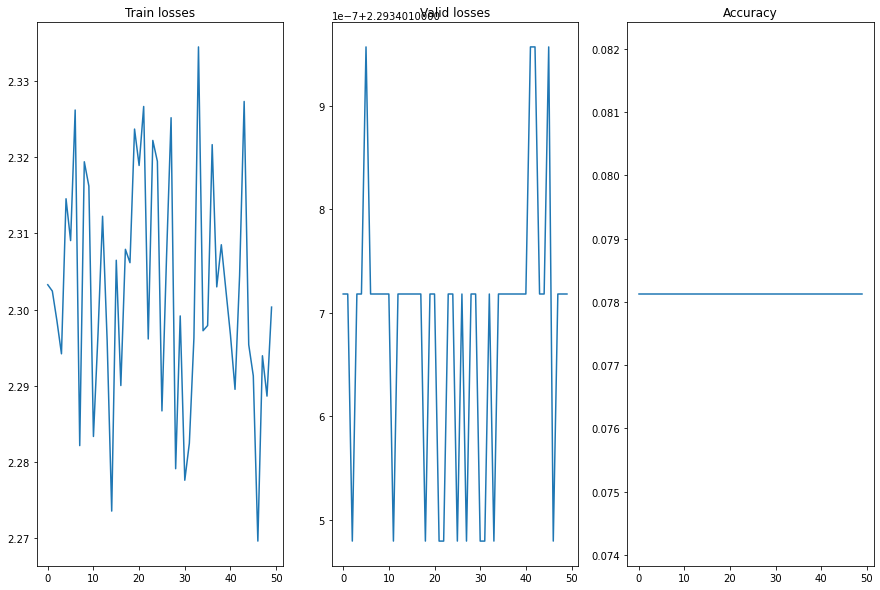

In [40]:
plot_losses(train_losses_musicnn, val_losses_musicnn, acc_epochs_musicnn)

In [41]:
mean_avg_musicnn = np.mean(acc_epochs_musicnn)
print("Mean average {}".format(mean_avg_musicnn))

Mean average 0.078125


## Jukebox (0-pad)

In [42]:
probe_jukebox = SimpleMLP(
            num_features = split_to_X["jukebox"]["train"].shape[1],
            hidden_layer_sizes = [512],
            num_outputs = DATASET_TO_ATTRS["dcase"]["num_outputs"],
            dropout_input=True,
            dropout_p=0.25,
        )

probe_jukebox.to(device)

SimpleMLP(
  (hidden_0): Linear(in_features=4800, out_features=512, bias=True)
  (output): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [43]:
std_scaler_jukebox = StandardScaler()
std_scaler_jukebox.fit(split_to_X["jukebox"]["train"])

scaler_dict["jukebox"] = std_scaler_jukebox

In [44]:
# Standard scaler
std_scaler_jukebox = StandardScaler()
X_train_jukebox = std_scaler_jukebox.fit_transform(split_to_X["jukebox"]["train"])
X_valid_jukebox = std_scaler_jukebox.fit_transform(split_to_X["jukebox"]["validation"])

scaler_dict["musicnn"] = std_scaler_musicnn

# Label encoding
le_jukebox = preprocessing.LabelEncoder()
y_train_jukebox = le_jukebox.fit_transform(split_to_y["jukebox"]["train"])
y_valid_jukebox = le_jukebox.fit_transform(split_to_y["jukebox"]["validation"])

le_dict["jukebox"] = le_jukebox

In [45]:
# Create optimizer
optimizer_jukebox = torch.optim.Adam(
    probe_jukebox.parameters(),
    lr=cfg["learning_rate"],
    weight_decay=0
    if cfg["l2_weight_decay"] is None
    else cfg["l2_weight_decay"],
)

In [46]:
train_losses_jukebox, val_losses_jukebox, acc_epochs_jukebox = train_valid_loop(X_train_jukebox, y_train_jukebox, X_valid_jukebox, y_valid_jukebox, probe_jukebox, cfg, std_scaler_jukebox, le_jukebox, optimizer_jukebox)

Epoch 10, train_loss: 2.386352062225342, valid_loss: 2.3352508544921875
                   precision    recall  f1-score   support

          airport       0.20      0.11      0.14         9
              bus       0.00      0.00      0.00         5
            metro       0.20      0.25      0.22         8
    metro_station       0.00      0.00      0.00         7
             park       0.00      0.00      0.00         4
    public_square       0.06      0.14      0.09         7
    shopping_mall       0.00      0.00      0.00         9
street_pedestrian       0.00      0.00      0.00         5
   street_traffic       0.00      0.00      0.00         6
             tram       0.15      0.50      0.24         4

         accuracy                           0.09        64
        macro avg       0.06      0.10      0.07        64
     weighted avg       0.07      0.09      0.07        64

Epoch 20, train_loss: 2.3620340824127197, valid_loss: 2.3352513313293457
                   precisi

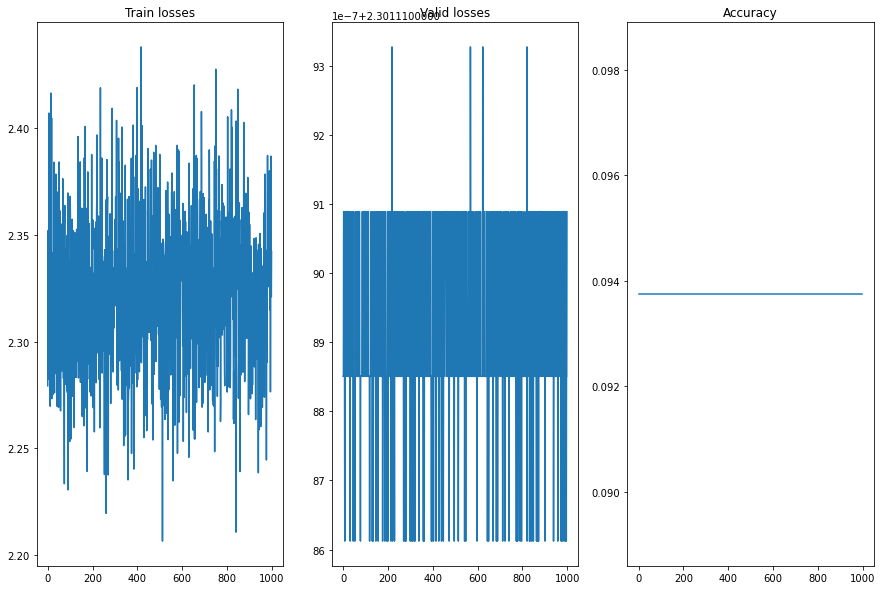

In [139]:
plot_losses(train_losses_jukebox, val_losses_jukebox, acc_epochs_jukebox)

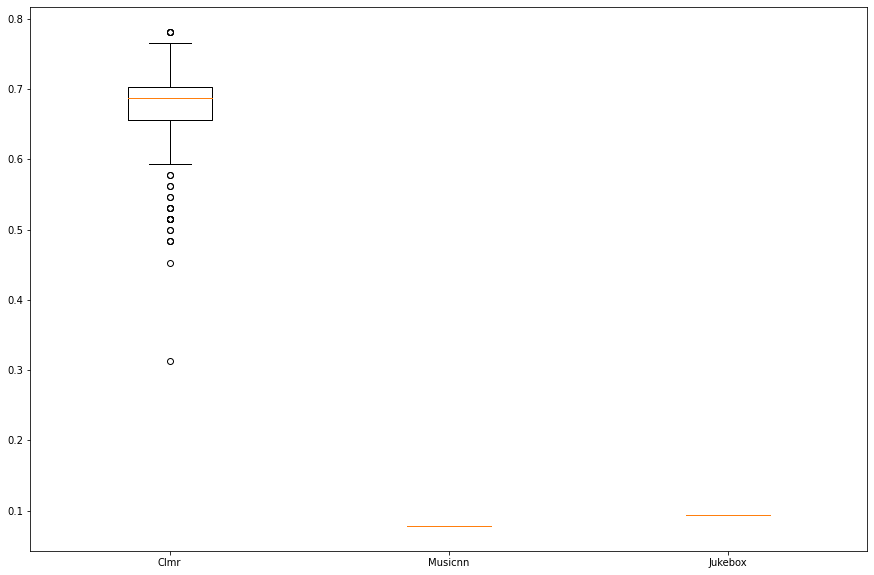

In [140]:
plt.rcParams["figure.figsize"] = (15,10)
plt.boxplot([acc_epochs, acc_epochs_musicnn, acc_epochs_jukebox], labels = ["Clmr","Musicnn","Jukebox"])
plt.show()

## PANN